In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm  
from helpers import load_dataset_paths, load_vep_csv, compute_class_average_signal, summarize_results_and_save
import pywt
from featex import FeatureExtractor
from CNN_classifier import CNN1D

## 0. Loading Preprocessed Files and Metadata

In [2]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")

PRIMA BC_Only files: 132
PRIMA RGC_Only files: 66
PRIMA BC_and_RGC files: 20


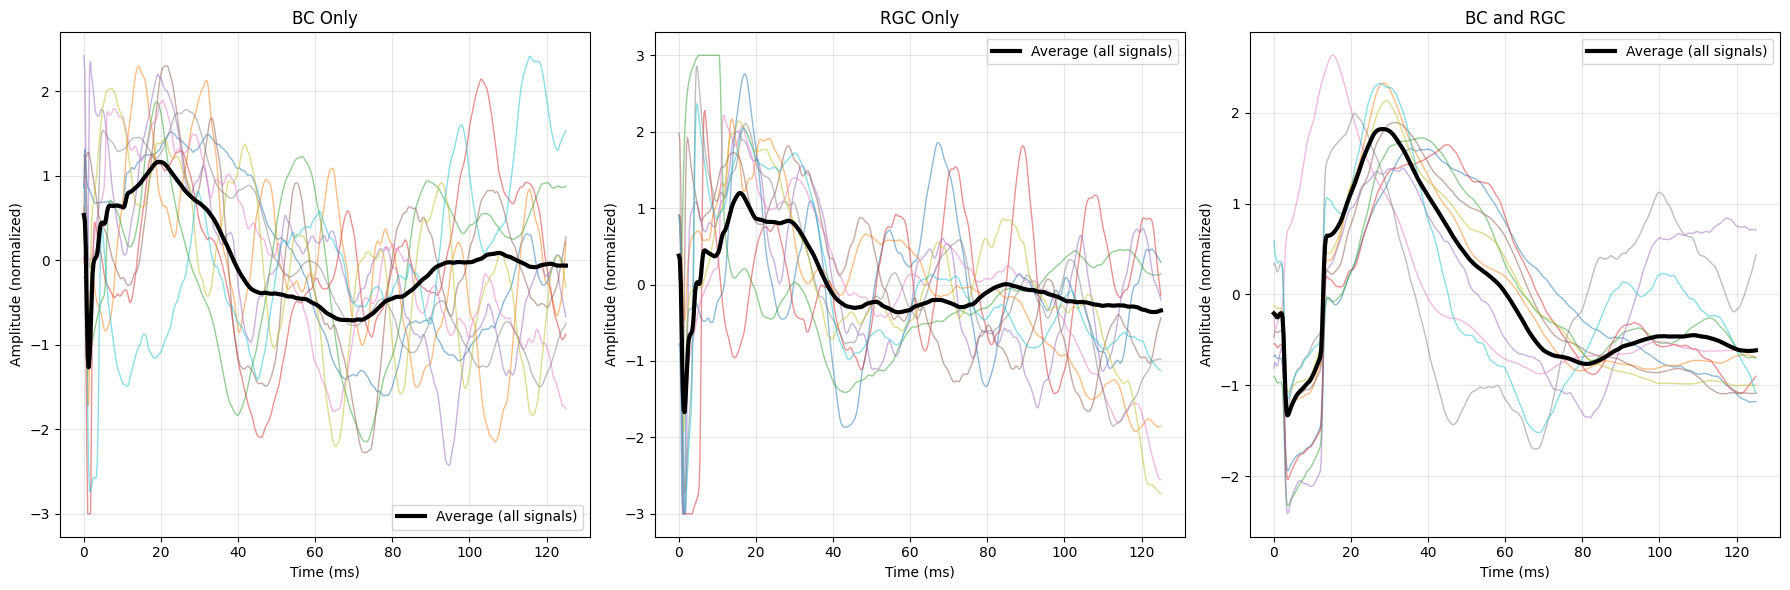

In [3]:
avg_BC_t, avg_BC_sig = compute_class_average_signal(prima_files_BC_only)
avg_RGC_t, avg_RGC_sig = compute_class_average_signal(prima_files_RGC_only)
avg_BC_RGC_t, avg_BC_RGC_sig = compute_class_average_signal(prima_files_BC_and_RGC)


# --- Choose 3 example files per category ---
example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(18, 6))

for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = load_vep_csv(file)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label="Average (all signals)")

    plt.title(title)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. DWT feature extraction

In [4]:
dwt_features, labels = [], []
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    files = prima_files_BC_only if label == "BC_Only" else \
            prima_files_RGC_only if label == "RGC_Only" else \
            prima_files_BC_and_RGC

    for file in tqdm(files, desc=f"Extracting {label}"):
        _, signal = load_vep_csv(file)
        X_dwt = FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4, max_length=100)
        dwt_features.append(X_dwt) 
        labels.append(label)

# Pad all to equal length (for CNN or ML)
max_len = max(len(f) for f in dwt_features)
dwt_features_padded = np.array([np.pad(f, (0, max_len - len(f))) for f in dwt_features])
labels = np.array(labels)


Extracting BC_and_RGC: 100%|██████████| 20/20 [00:00<00:00, 1960.37it/s]


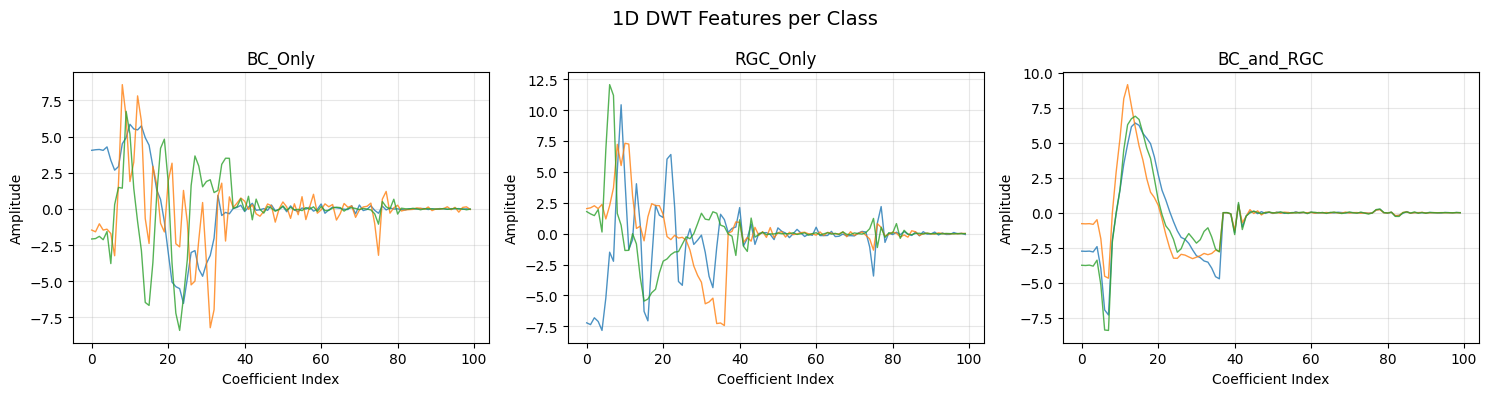

In [5]:
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

# --- Plot 1D DWT features per class ---
plt.figure(figsize=(15, 4))
for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Get up to 3 examples from this class
    class_indices = np.where(labels == label)[0][:3]
    
    for idx in class_indices:
        plt.plot(dwt_features_padded[idx], lw=1, alpha=0.8)
    
    plt.title(f"{label}")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)

plt.suptitle("1D DWT Features per Class", fontsize=14)
plt.tight_layout()
plt.show()

## Classification

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

average_results = {}

signal_types = ["Raw", "DWT"]

for signal_type in signal_types:
    print(f"\n=== Processing Signal Type: {signal_type} ===")
    results = []
    all_conf_matrices = []
    for experiments in range(10):
        print(f"--- Experiment {experiments + 1} ---")
        np.random.seed(42)
        no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
        sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
        sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
        sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

        X, labels = [], []
        for file in sampled_BC:
            _, signal = load_vep_csv(file, t_min=0, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("BC_Only")
        for file in sampled_RGC:
            _, signal = load_vep_csv(file, t_min=0, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("RGC_Only")
        for file in sampled_BC_and_RGC:
            _, signal = load_vep_csv(file, t_min=0, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("BC_and_RGC")

        n_train = len(X)
        print(f"Number of training samples: {n_train}")
        batch_size = max(4, min(32, n_train // 10))

        print(f"Using batch size: {batch_size}")
        if n_train < 100:
            epochs = 50
        elif n_train < 500:
            epochs = 35
        else:
            epochs = 20
        print(f"Using epochs: {epochs}")

        clf = CNN1D(X, labels, model_type="cnn", n_splits=5, random_state=42)
        y_true, y_pred = clf.fit(epochs=epochs, batch_size=batch_size)
        metrics = clf.evaluate(y_true, y_pred)

        results.append({
                "Accuracy": metrics["accuracy"],
                "BalancedAcc": metrics["balanced_accuracy"],
                "F1": metrics["f1_score"],
                "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
                "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
                "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
            })
        all_conf_matrices.append(
            confusion_matrix(
                y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
            )
        )

    accs = [r["Accuracy"] for r in results]
    balanced_accs = [r["BalancedAcc"] for r in results]
    f1s = [r["F1"] for r in results]
    bc_accs = [float(r["Acc BC_Only"]) for r in results]
    rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
    bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

    average_results[(signal_type)] = {
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "BalancedAcc_mean": np.mean(balanced_accs),
        "BalancedAcc_std": np.std(balanced_accs),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),

        # per-class accuracies (recall)
        "Acc_BC_Only_mean": np.mean(bc_accs),
        "Acc_BC_Only_std": np.std(bc_accs),
        "Acc_RGC_Only_mean": np.mean(rgc_accs),
        "Acc_RGC_Only_std": np.std(rgc_accs),
        "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
        "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
    }
    mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
    mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

    labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

    plt.figure(figsize=(6,5))
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'})

    plt.title(f"Mean Confusion Matrix ({signal_type})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()




=== Processing Signal Type: Raw ===
--- Experiment 1 ---
Number of training samples: 60
Using batch size: 6
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Fold 1 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Fold 2 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Fold 3 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Fold 4 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Fold 5 done
[[10  8  2]
 [ 4 13  3]
 [ 1  1 18]]
--- Experiment 2 ---
Number of training samples: 60
Using batch size: 6
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Fold 1 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Fold 2 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Fold 3 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Fold 4 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Fold 5 done
[[10  6  4]
 [ 4 12  4]
 [ 0  0 20]]
--- Experiment 3 ---
Number of training samples: 60
Using batch size: 6
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Fold 1 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Fold 2 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 3 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold 4 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold 5 done
[[11  5  4]
 [ 5 13  2]
 [ 1  0 19]]
--- Experiment 4 ---
Number of training samples: 60
Using batch size: 6
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold 1 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 2 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 3 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold 4 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 5 done
[[ 8 11  1]
 [ 2 14  4]
 [ 2  1 17]]
--- Experiment 5 ---
Number of training samples: 60
Using batch size: 6
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 1 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 2 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold 3 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 4 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 5 done
[[ 9  8  3]
 [ 3 15  2]
 [ 0  0 20]]
--- Experiment 6 ---
Number of training samples: 60
Using batch size: 6
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 1 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Fold 2 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 3 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Fold 4 done


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
summarize_results_and_save(average_results, model_name="1DCNN")


Top 10 setups by F1 Score:
Model Feature_Type F1 (mean ± std) BC_Only (mean ± std) RGC_Only (mean ± std) BC_and_RGC (mean ± std)
1DCNN          DWT     0,798 ± 0,0            0,7 ± 0,0            0,75 ± 0,0              0,95 ± 0,0
1DCNN          Raw     0,704 ± 0,0           0,55 ± 0,0             0,6 ± 0,0               1,0 ± 0,0

Summary saved to: results/1DCNN_average_classification_results.csv
